In [0]:
from google.colab import drive
drive.mount('/content/drive')

Домашнее задание:

Задание Light:
Вычислить HoG признаки для Lena30.jpg. Можно с помощью opencv или skimage.feature. Визуализировать результат.
 
Задание Pro:
Сделать классификатор открытый - закрытый глаз с помощью признаков для изображения. 
Для зарузки файлов eyes_test.npz и eyes_train.npz использовать копию ноутбука dz_ml2_eyes.ipynb 
База - https://www.dropbox.com/s/bm1u6lkx6owy2fk/eyes.zip?dl=0 
Ноутбук - https://colab.research.google.com/drive/1AVbY3qihYa79B4O_jSg8xRBMjWhP6T43
В качестве признаков рекомендуется использовать одновременно HoG и LBP.
Сам алгоритм может быть такой же, как в предыдущем домашнем задании для классического машинного обучения про классификатор лицо-не лицо. Только вместо интенсивностей используются признаки. Для одновременного использования признаков HoG и LBP можно сделать отдельно методы главных компонент для каждого типа признаков, сконкатенировать преобразованные признаки в один вектор и затем запускать классификатор, например SVM.
В отчет - описание построенного классификатора и ошибки первого и второго рода, accuracy.
Опционально - прогнать полученный алгоритм на базе лицо-не лицо
Опционально - обучить сверточную сеть классифицировать открытый - закрытый глаз, лицо - не лицо.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from skimage import data, exposure
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics


#Загрузка данных

In [0]:
#!wget https://www.dropbox.com/s/bm1u6lkx6owy2fk/eyes.zip
#!unzip -q eyes.zip
#!ls

def load_data():
  data = np.load('eyes_train.npz')
  train_X = data["images"]
  train_Y = data["labels"]

  data = np.load('eyes_test.npz')
  test_X = data["images"]
  test_Y = data["labels"]
  return(train_X,train_Y,test_X,test_Y)

train_X,train_Y,test_X,test_Y = load_data()

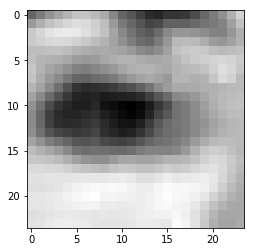

In [0]:
image = train_X[0]
plt.figure()
plt.imshow(image, cmap='gray')
plt.show()




#Визуализация HOG и LBP

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


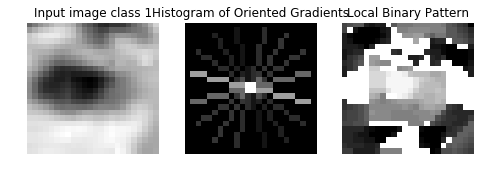

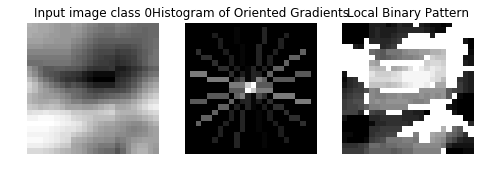

In [0]:
METHOD = 'uniform'
radius = 5
n_points = 5 * radius
pixels_per_cell=(24, 24)
image = train_X[train_Y==1][0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image class 1')

fd, hog_image = hog(image, orientations=8, pixels_per_cell=pixels_per_cell,
                    cells_per_block=(1, 1), visualize=True)#, multichannel=True)
lbp = local_binary_pattern(image, n_points, radius, METHOD)


# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

ax3.axis('off')
ax3.imshow(lbp, cmap=plt.cm.gray)
ax3.set_title('Local Binary Pattern')
plt.show()


image = train_X[train_Y==0][0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image class 0')

fd, hog_image = hog(image, orientations=8, pixels_per_cell=pixels_per_cell,
                    cells_per_block=(1, 1), visualize=True)#, multichannel=True)
lbp = local_binary_pattern(image, n_points, radius, METHOD)


# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

ax3.axis('off')
ax3.imshow(lbp, cmap=plt.cm.gray)
ax3.set_title('Local Binary Pattern')
plt.show()


#Вычисление признаков, стандартизация

In [0]:
def preprocess(train_X,test_X, hog_orientations=8, hog_pixels_per_cell=24, lbp_radius = 3, lbp_n_points = 8):
  def hog_feat(image):
    return hog(image, orientations=hog_orientations, pixels_per_cell=(hog_pixels_per_cell, hog_pixels_per_cell), cells_per_block=(1, 1))

  def lbp_feat(image,method = 'uniform', radius = lbp_radius, n_points = lbp_n_points ):
    return local_binary_pattern(image, n_points * radius, radius, method).ravel()

  hog_train_X = np.array(list(map(lambda x : hog_feat(x), train_X)))
  hog_test_X = np.array(list(map(lambda x : hog_feat(x), test_X)))

  lbp_train_X = np.array(list(map(lambda x : lbp_feat(x), train_X)))
  lbp_test_X = np.array(list(map(lambda x : lbp_feat(x), test_X)))

  mean = hog_train_X.mean(0)
  std = hog_train_X.std(0)

  hog_train_X -= mean
  hog_train_X /= std

  hog_test_X -= mean
  hog_test_X /= std

  mean = lbp_train_X.mean(0)
  std = lbp_train_X.std(0)

  lbp_train_X -= mean
  lbp_train_X /= std

  lbp_test_X -= mean
  lbp_test_X /= std
  return(hog_train_X,hog_test_X,lbp_train_X,lbp_test_X)

hog_train_X,hog_test_X,lbp_train_X,lbp_test_X = preprocess(train_X,test_X)


#PCA

(3200, 7)
(800, 7)


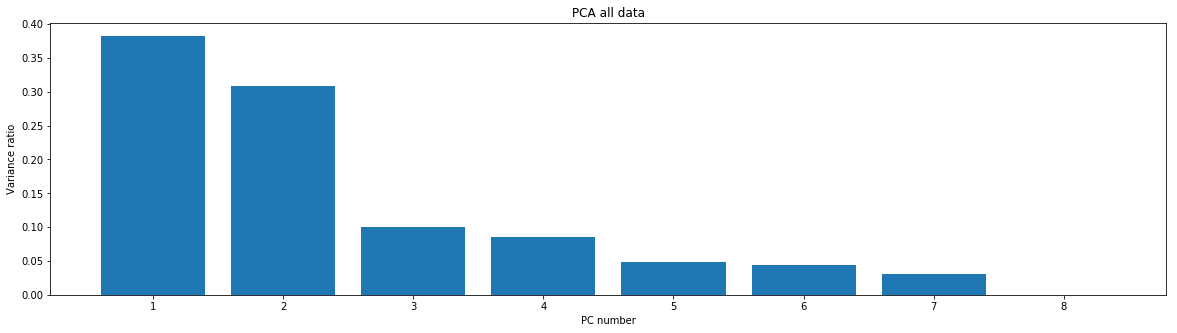

In [0]:
#метод главных компонент для HOG
from sklearn.decomposition import PCA
flen=hog_train_X.shape[1]
hog_pca = PCA(n_components=flen)
hog_pca.fit(hog_train_X)

plt.figure(figsize=(20,5))
plt.bar(np.arange(1,flen+1), hog_pca.explained_variance_ratio_ ,tick_label=np.arange(1,flen+1))
plt.ylabel("Variance ratio")
plt.xlabel("PC number")
plt.title("PCA all data")

hog_pca = PCA(n_components=.99)
hog_pca.fit(hog_train_X)
#преобразуем обучающую выборку
hog_pca_train_X = hog_pca.transform(hog_train_X)
print(hog_pca_train_X.shape)
#преобразуем тестовую выборку
hog_pca_test_X = hog_pca.transform(hog_test_X)
print(hog_pca_test_X.shape)

(3200, 538)
(800, 538)


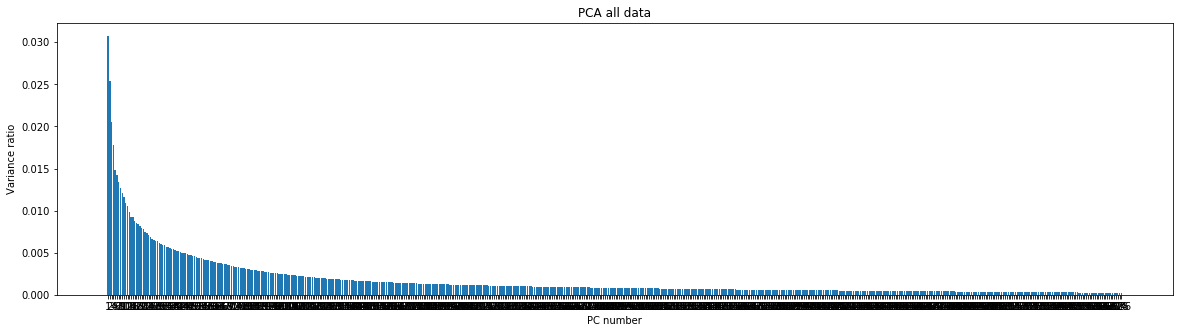

In [0]:
#метод главных компонент для LBP
flen=lbp_train_X.shape[1]
lbp_pca = PCA(n_components=flen)
lbp_pca.fit(lbp_train_X)

plt.figure(figsize=(20,5))
plt.bar(np.arange(1,flen+1), lbp_pca.explained_variance_ratio_ ,tick_label=np.arange(1,flen+1))
plt.ylabel("Variance ratio")
plt.xlabel("PC number")
plt.title("PCA all data")

lbp_pca = PCA(n_components=.99)
lbp_pca.fit(lbp_train_X)
#преобразуем обучающую выборку
lbp_pca_train_X = lbp_pca.transform(lbp_train_X)
print(lbp_pca_train_X.shape)
#преобразуем тестовую выборку
lbp_pca_test_X = lbp_pca.transform(lbp_test_X)
print(lbp_pca_test_X.shape)

#Объединяем главные компоненты hog и lbp признаков

In [0]:

train_X = np.concatenate((hog_pca_train_X,lbp_pca_train_X),axis=1)
print(train_X.shape)

test_X = np.concatenate((hog_pca_test_X,lbp_pca_test_X),axis=1)
print(test_X.shape)


(3200, 545)
(800, 545)


In [0]:
def pca_transform(train_X,test_X,n_components=.99):
  pca = PCA(n_components=n_components)
  pca.fit(train_X)
  #преобразуем обучающую выборку
  pca_train_X = pca.transform(train_X)
  #преобразуем тестовую выборку
  pca_test_X = pca.transform(test_X)
  return(pca_train_X,pca_test_X)

#метод опорных векторов
def svc_predict(train_X, train_Y, test_X):
  clf = svm.SVC(kernel = 'linear')
  clf.fit(train_X, train_Y)
  return clf.predict(test_X)

#вычисление ошибок первого и второго рода
def printErrlabelsTest(labelsTest,labelsPredict):
    acc = metrics.accuracy_score(labelsTest, labelsPredict)
    print("Accuracy:", acc)
    FP = sum((labelsTest == 0) & (labelsPredict == 1))
    FN = sum((labelsTest == 1) & (labelsPredict == 0))
    TP = sum((labelsTest == 1) & (labelsPredict == 1))
    TN = sum((labelsTest == 0) & (labelsPredict == 0))
    FPR = FP / (FP + TN)
    print('ERR1 ', FPR)
    FNR = FN / (TP + FN)
    print('ERR2 ', FNR)

train_X,train_Y,test_X,test_Y = load_data()

hog_train_X,hog_test_X,lbp_train_X,lbp_test_X = preprocess(train_X,test_X)

hog_pca_train_X,hog_pca_test_X = pca_transform(hog_train_X,hog_test_X)
lbp_pca_train_X,lbp_pca_test_X = pca_transform(lbp_train_X,lbp_test_X)

train_X = np.concatenate((hog_pca_train_X,lbp_pca_train_X),axis=1)
print(train_X.shape)

test_X = np.concatenate((hog_pca_test_X,lbp_pca_test_X),axis=1)
print(test_X.shape)

predict_Y = svc_predict(train_X, train_Y, test_X)
printErrlabelsTest(test_Y,predict_Y) 


/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


(3200, 545)
(800, 545)
Accuracy: 0.83875
ERR1  0.14066496163682865
ERR2  0.18092909535452323


#Подбор оптимальных параметров

In [0]:
def tune_predict(params):
  hog_orientations=params['hog_orientations']
  hog_pixels_per_cell=params['hog_pixels_per_cell']
  lbp_radius = params['lbp_radius']
  lbp_n_points = params['lbp_n_points']
  n_components = params['n_components']
  
  #загрузка данных
  train_X,train_Y,test_X,test_Y = load_data()
  #расчет hog,lbp признаков, стандартизация
  hog_train_X,hog_test_X,lbp_train_X,lbp_test_X = preprocess(train_X,test_X, hog_orientations, hog_pixels_per_cell, lbp_radius, lbp_n_points)
  #главные компоненты hog,lbp признаков
  hog_pca_train_X,hog_pca_test_X = pca_transform(hog_train_X,hog_test_X)
  lbp_pca_train_X,lbp_pca_test_X = pca_transform(lbp_train_X,lbp_test_X)
  #объединение главных компонент hog,lbp признаков
  train_X = np.concatenate((hog_pca_train_X,lbp_pca_train_X),axis=1)
  test_X = np.concatenate((hog_pca_test_X,lbp_pca_test_X),axis=1)
  #метод опорных векторов
  predict_Y = svc_predict(train_X, train_Y, test_X)
  #return metrics.accuracy_score(test_Y, predict_Y)
  return predict_Y
  
#целевая функция минимизации (для поиска гиперпараметров)
def objective(params):
  np.random.seed(42)
  random.seed(13)

  predict_Y = tune_predict(params)
  validation_acc = metrics.accuracy_score(test_Y, predict_Y)
  
  return {'loss': -validation_acc, 'status': STATUS_OK}  

def space_eval_trial(space, trial):
    for_eval = {}
    for k, v in trial["misc"]["vals"].items():
        if len(v) == 0:
            for_eval[k] = None
        else:
            for_eval[k] = v[0]
    return space_eval(space, for_eval)



In [0]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval
import random
#параметры оптимизации
space = { 'hog_orientations' : 3,#hp.choice('hog_orientations', [2,3,4]), 
          'hog_pixels_per_cell' : hp.choice('hog_pixels_per_cell', [10,12,14]), 
          'lbp_radius' : hp.choice('lbp_radius', [2,4,6]), 
          'lbp_n_points' : hp.choice('lbp_n_points', [8,9,10]), 
          'n_components' : .95
        }

  
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=10)

print (best)

for trial in sorted(trials, key=lambda x: x['result']['loss'], reverse=False):
  print(-trial['result']['loss'],space_eval_trial(space, trial))

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 10%|█         | 1/10 [00:23<03:34, 23.78s/it, best loss: -0.8525]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 20%|██        | 2/10 [00:52<03:22, 25.27s/it, best loss: -0.86125]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 30%|███       | 3/10 [01:09<02:38, 22.66s/it, best loss: -0.87125]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 40%|████      | 4/10 [01:29<02:11, 21.99s/it, best loss: -0.87125]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 50%|█████     | 5/10 [01:44<01:39, 19.93s/it, best loss: -0.87875]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 60%|██████    | 6/10 [02:44<02:07, 31.92s/it, best loss: -0.87875]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 70%|███████   | 7/10 [03:05<01:25, 28.62s/it, best loss: -0.87875]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 80%|████████  | 8/10 [03:32<00:56, 28.17s/it, best loss: -0.87875]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 90%|█████████ | 9/10 [03:59<00:27, 27.75s/it, best loss: -0.87875]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



100%|██████████| 10/10 [04:20<00:00, 25.67s/it, best loss: -0.87875]
{'hog_pixels_per_cell': 0, 'lbp_n_points': 0, 'lbp_radius': 0}
0.87875 {'hog_orientations': 3, 'hog_pixels_per_cell': 10, 'lbp_n_points': 8, 'lbp_radius': 2, 'n_components': 0.95}
0.87125 {'hog_orientations': 3, 'hog_pixels_per_cell': 10, 'lbp_n_points': 9, 'lbp_radius': 2, 'n_components': 0.95}
0.86125 {'hog_orientations': 3, 'hog_pixels_per_cell': 12, 'lbp_n_points': 8, 'lbp_radius': 2, 'n_components': 0.95}
0.8525 {'hog_orientations': 3, 'hog_pixels_per_cell': 12, 'lbp_n_points': 9, 'lbp_radius': 2, 'n_components': 0.95}
0.8525 {'hog_orientations': 3, 'hog_pixels_per_cell': 12, 'lbp_n_points': 10, 'lbp_radius': 2, 'n_components': 0.95}
0.85 {'hog_orientations': 3, 'hog_pixels_per_cell': 10, 'lbp_n_points': 10, 'lbp_radius': 4, 'n_components': 0.95}
0.85 {'hog_orientations': 3, 'hog_pixels_per_cell': 10, 'lbp_n_points': 10, 'lbp_radius': 4, 'n_components': 0.95}
0.845 {'hog_orientations': 3, 'hog_pixels_per_cell': 1

In [0]:
#0.87875 {'hog_orientations': 3, 'hog_pixels_per_cell': 10, 'lbp_n_points': 8, 'lbp_radius': 2, 'n_components': 0.95}
#параметры оптимизации
space = { 'hog_orientations' : hp.choice('hog_orientations', [5,6,7,8]), 
          'hog_pixels_per_cell' : 2,#hp.choice('hog_pixels_per_cell', [2,4,6,8]), 
          'lbp_radius' : 2,#hp.choice('lbp_radius', [1,2]), 
          'lbp_n_points' : hp.choice('lbp_n_points', [6,8,10]), 
          'n_components' : .95
        }

  
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=10)

print (best)

for trial in sorted(trials, key=lambda x: x['result']['loss'], reverse=False):
  print(-trial['result']['loss'],space_eval_trial(space, trial))

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 10%|█         | 1/10 [00:16<02:27, 16.42s/it, best loss: -0.92625]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 20%|██        | 2/10 [00:30<02:06, 15.78s/it, best loss: -0.92625]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 30%|███       | 3/10 [00:46<01:49, 15.70s/it, best loss: -0.9275] 

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 40%|████      | 4/10 [01:04<01:39, 16.61s/it, best loss: -0.9425]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 50%|█████     | 5/10 [01:19<01:19, 15.85s/it, best loss: -0.9425]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 60%|██████    | 6/10 [01:33<01:01, 15.43s/it, best loss: -0.9425]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 70%|███████   | 7/10 [01:50<00:47, 15.99s/it, best loss: -0.9425]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 80%|████████  | 8/10 [02:09<00:33, 16.76s/it, best loss: -0.9425]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



 90%|█████████ | 9/10 [02:28<00:17, 17.34s/it, best loss: -0.9425]

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)



100%|██████████| 10/10 [02:45<00:00, 17.37s/it, best loss: -0.9425]
{'hog_orientations': 3, 'lbp_n_points': 0}
0.9425 {'hog_orientations': 8, 'hog_pixels_per_cell': 2, 'lbp_n_points': 6, 'lbp_radius': 2, 'n_components': 0.95}
0.9425 {'hog_orientations': 8, 'hog_pixels_per_cell': 2, 'lbp_n_points': 6, 'lbp_radius': 2, 'n_components': 0.95}
0.9425 {'hog_orientations': 8, 'hog_pixels_per_cell': 2, 'lbp_n_points': 6, 'lbp_radius': 2, 'n_components': 0.95}
0.9275 {'hog_orientations': 6, 'hog_pixels_per_cell': 2, 'lbp_n_points': 6, 'lbp_radius': 2, 'n_components': 0.95}
0.92625 {'hog_orientations': 6, 'hog_pixels_per_cell': 2, 'lbp_n_points': 10, 'lbp_radius': 2, 'n_components': 0.95}
0.92375 {'hog_orientations': 5, 'hog_pixels_per_cell': 2, 'lbp_n_points': 8, 'lbp_radius': 2, 'n_components': 0.95}
0.92375 {'hog_orientations': 5, 'hog_pixels_per_cell': 2, 'lbp_n_points': 8, 'lbp_radius': 2, 'n_components': 0.95}
0.92375 {'hog_orientations': 7, 'hog_pixels_per_cell': 2, 'lbp_n_points': 10, 'l

In [0]:
#0.9425 {'hog_orientations': 8, 'hog_pixels_per_cell': 2, 'lbp_n_points': 6, 'lbp_radius': 2, 'n_components': 0.95}
params = {'hog_orientations': 8, 'hog_pixels_per_cell': 2, 'lbp_n_points': 6, 'lbp_radius': 2, 'n_components': 0.95}

np.random.seed(42)
random.seed(13)

predict_Y = tune_predict(params)
validation_acc = metrics.accuracy_score(test_Y, predict_Y)
print(validation_acc)

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


0.9425


In [0]:
printErrlabelsTest(test_Y,predict_Y) 

Accuracy: 0.9425
ERR1  0.03836317135549872
ERR2  0.07579462102689487


In [0]:
#https://colab.research.google.com/drive/1lOvEJj5tEe9i4lU8UyMSG1oDP4U91Ut5
  
Для решения задачииспользован SVM классификатор, в качестве признаков использовано объединение главных компонент признаков (n_components=0.95) Histogram of Oriented Gradients (HOG) и LBP (Local Binary Pattern), методом оптимизации выбраны параметры для 
HOG: orientations=8, pixels_per_cell=(2,2)
LBP: radius=2, кол. соседних точек n_points=6*radius

Accuracy: 0.9425
ERR1  0.03836317135549872
ERR2  0.07579462102689487